In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e12/sample_submission.csv
/kaggle/input/playground-series-s4e12/train.csv
/kaggle/input/playground-series-s4e12/test.csv


In [3]:
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from catboost import CatBoostRegressor

In [6]:
df = pd.read_csv("/kaggle/input/playground-series-s4e12/train.csv")
# df.head()

In [ ]:
df_test = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv")
df_test.head()

In [ ]:
df.info()

In [ ]:
df.describe().round(1)

In [ ]:
df.isna().sum()

In [ ]:
sns.heatmap(df.isna().sort_values(by=["Occupation"]) == True)

In [7]:
# df.dropna(inplace = True)
for non_object_column in df.select_dtypes(exclude = "object").columns:
    df[non_object_column].fillna(df[non_object_column].mean(), inplace = True)

df.dropna(inplace = True)

In [6]:
df.shape

(775274, 21)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(df.select_dtypes(exclude = "object").corr(), annot = True, cmap = "Reds")

In [ ]:
df_categorical = df.select_dtypes('object')
for object_column in df_categorical.columns:
    print(object_column, {df[object_column].nunique()}, ': ', df[object_column].unique(), '\n')

In [8]:
df.drop(['id', 'Policy Start Date'], axis = 1, inplace = True)

In [ ]:
for non_object_column in df.select_dtypes(exclude = "object").columns:
    if non_object_column != 'Premium Amount':
        df[non_object_column] = df[non_object_column] / df[non_object_column].max()

In [ ]:
df.head()

In [ ]:
df["Policy Start Date"] = pd.to_datetime(df["Policy Start Date"].apply(lambda x: x[:10]))

In [ ]:
pd.get_dummies(df_categorical, drop_first = True, dtype = int)

In [9]:
df = pd.concat(
    [
        df.select_dtypes(exclude = "object"), 
        pd.get_dummies(df.select_dtypes('object'), drop_first = True, dtype = int)
    ],
    axis = "columns"
)
df.head()

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Gender_Male,...,Policy Type_Comprehensive,Policy Type_Premium,Customer Feedback_Good,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
0,19.0,10049.0,1.0,22.598761,2.0,17.0,372.00000,5.0,2869.0,0,...,0,1,0,1,0,0,0,1,0,1
2,23.0,25602.0,3.0,47.177549,1.0,14.0,592.92435,3.0,567.0,1,...,0,1,1,0,1,0,0,1,0,1
4,21.0,39651.0,1.0,20.376094,0.0,8.0,598.00000,4.0,2022.0,1,...,0,1,0,1,1,0,0,1,0,1
7,48.0,127237.0,2.0,5.769783,1.0,11.0,398.00000,5.0,111.0,0,...,1,0,0,0,0,0,1,0,1,0
9,44.0,52447.0,2.0,20.473718,1.0,9.0,635.00000,3.0,64.0,1,...,1,0,0,1,0,0,0,0,1,0


In [10]:
df.to_csv("train_new.csv", index=False)

In [5]:
df = pd.read_csv("/kaggle/working/train_new.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/train_new.csv'

In [9]:
df.dtypes

Age                            float64
Annual Income                  float64
Number of Dependents           float64
Health Score                   float64
Previous Claims                float64
Vehicle Age                    float64
Credit Score                   float64
Insurance Duration             float64
Premium Amount                 float64
Gender_Male                      int64
Marital Status_Married           int64
Marital Status_Single            int64
Education Level_High School      int64
Education Level_Master's         int64
Education Level_PhD              int64
Occupation_Self-Employed         int64
Occupation_Unemployed            int64
Location_Suburban                int64
Location_Urban                   int64
Policy Type_Comprehensive        int64
Policy Type_Premium              int64
Customer Feedback_Good           int64
Customer Feedback_Poor           int64
Smoking Status_Yes               int64
Exercise Frequency_Monthly       int64
Exercise Frequency_Rarely

In [11]:
df.describe()

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Gender_Male,...,Policy Type_Comprehensive,Policy Type_Premium,Customer Feedback_Good,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
count,775274.000000,775274.000000,775274.000000,775274.000000,775274.000000,775274.000000,775274.000000,775274.000000,775274.000000,775274.000000,...,775274.000000,775274.000000,775274.000000,775274.000000,775274.000000,775274.000000,775274.000000,775274.000000,775274.000000,775274.000000
mean,41.148867,32294.908373,2.008073,25.611307,1.001807,9.580240,591.494932,5.019517,1098.686541,0.502064,...,0.333367,0.334941,0.327967,0.334271,0.501668,0.249401,0.249103,0.255400,0.332827,0.333280
std,13.431284,31135.470133,1.350615,11.822272,0.819426,5.774261,141.496247,2.595893,865.133053,0.499996,...,0.471417,0.471970,0.469473,0.471735,0.499998,0.432667,0.432494,0.436086,0.471225,0.471386
min,18.000000,2.000000,0.000000,2.024415,0.000000,0.000000,300.000000,1.000000,20.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,8791.000000,1.000000,16.551470,0.000000,5.000000,481.000000,3.000000,511.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,41.145563,24881.000000,2.000000,25.613908,1.000000,10.000000,592.924350,5.000000,867.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,53.000000,43787.000000,3.000000,33.754214,1.002689,15.000000,705.000000,7.000000,1502.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,64.000000,149997.000000,4.000000,58.975914,8.000000,19.000000,849.000000,9.000000,4997.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x7f899a071b10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f899a070c40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f899a070280>],
 'medians': [<matplotlib.lines.Line2D at 0x7f899a070ee0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f899a071210>],
 'means': []}

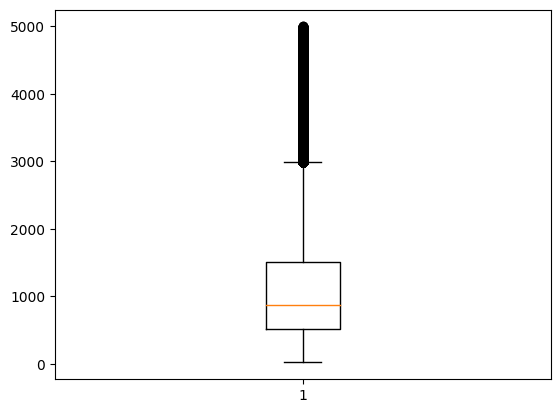

In [11]:
plt.boxplot(df['Premium Amount'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f899a118a90>,
 'caps': [<matplotlib.lines.Line2D at 0x7f899a1187c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f899a1185e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f899a1182b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f899a118550>],
 'means': []}

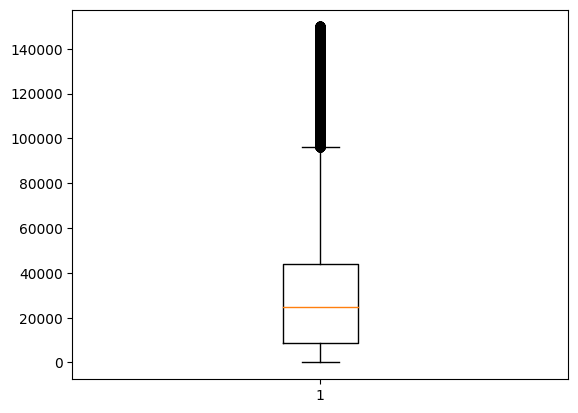

In [12]:
plt.boxplot(df['Annual Income'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f899a081d80>,
 'caps': [<matplotlib.lines.Line2D at 0x7f899a0830d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f899a081210>],
 'medians': [<matplotlib.lines.Line2D at 0x7f899a0839a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f899a0a1600>],
 'means': []}

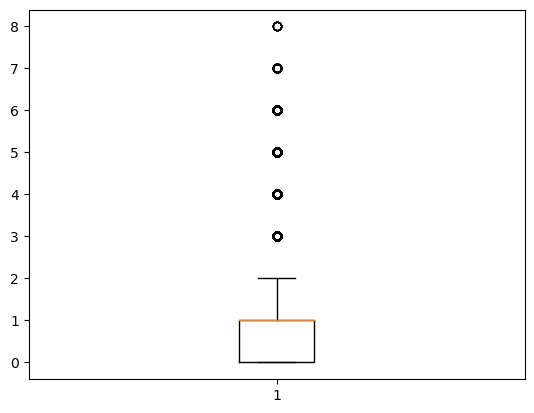

In [13]:
plt.boxplot(df['Previous Claims'])

In [17]:
df[df['Previous Claims'] > 2]['Age'].count()

39807

In [18]:
df[df['Annual Income'] > 100_000]['Age'].count()

41241

In [31]:
df[(df['Previous Claims'] > 2) | (df['Annual Income'] > 100_000) | (df['Premium Amount'] > 3000)]['Age'].count()

105085

In [22]:
df['Age'].count()

775274

In [11]:
df2 = df[(df['Previous Claims'] > 2) | (df['Annual Income'] > 100_000) | (df['Premium Amount'] > 3_000)]
df2['Age'].count()

105085

In [12]:
df = df[(df['Previous Claims'] <= 2) & (df['Annual Income'] <= 100_000) & (df['Premium Amount'] <= 3000)]
df['Age'].count()

670189

In [13]:
x = df.drop(['Premium Amount'], axis = 1)
y = df['Premium Amount']

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [15]:
model1 = LinearRegression()
model2 = RandomForestRegressor(n_estimators=28, random_state=0)
model3 = PolynomialFeatures(degree=4)
model4 = CatBoostRegressor(
                            # iterations=1000,
                            learning_rate=0.01,
                            depth = 9,
                            n_estimators = 1000,
                            verbose = False
)

In [ ]:
x_train = model3.fit_transform(x_train)
x_test = model3.fit_transform(x_test)
x = model3.fit_transform(x)

In [16]:
# model = model3
# model.fit(model3.fit_transform(x_train))

# model = model1
# model.fit(model3.fit(model3.fit_transform(x_train)), y_train)

model = model4
model.fit(x_train, y_train)

In [17]:
y_pred = model.predict(x_test)

In [18]:
def rmsle(predictions, targets):
    """Calculate the root mean squared logarithmic error between predictions and targets"""
    return np.sqrt(np.mean((np.log(predictions + 1) - np.log(targets + 1)) ** 2))

In [19]:
df_pred = pd.DataFrame([y_pred, y_test]).transpose()
df_pred = df_pred.describe()
df_pred['diff'] = df_pred[0] - df_pred[1]
df_pred['0/1'] = df_pred[0] / df_pred[1]
df_pred

,0,1,diff,0/1
count,134038.000000,134038.000000,0.000000,1.000000
mean,992.451371,991.799035,0.652336,1.000658
std,157.781792,698.634414,-540.852622,0.225843
min,265.544335,20.000000,245.544335,13.277217
25%,986.640818,500.000000,486.640818,1.973282
50%,1006.233252,828.000000,178.233252,1.215258
75%,1040.041452,1385.000000,-344.958548,0.750932
max,1390.050284,2998.000000,-1607.949716,0.463659


<ipython-input-121-57f1de8a0ccb>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


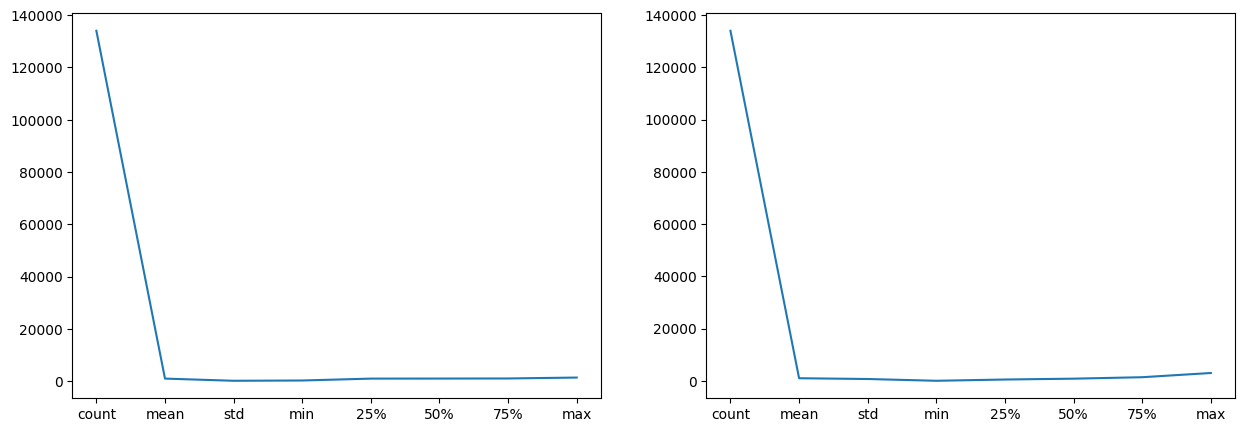

In [121]:
fig, ax = plt.subplots(figsize=(15, 5), sharey=True)
plt.subplot(1, 2, 1)
plt.plot(df_pred[0][:1000])
plt.subplot(1, 2, 2)
plt.plot(df_pred[1][:1000])

In [20]:
rmsle(y_pred, y_test)

1.074362597413997

In [21]:
rmsle(y_pred-219.25, y_test)

1.0209858584510572

In [22]:
model.fit(x, y)

In [58]:
x.shape

(670189, 28)

In [23]:
df_test = pd.read_csv("/kaggle/input/playground-series-s4e12/test.csv")

# for non_object_column in df_test.select_dtypes(exclude = "object").columns:
#     df_test[non_object_column] = df_test[non_object_column] / df_test[non_object_column].max()

for non_object_column in df_test.select_dtypes(exclude = "object").columns:
    df_test[non_object_column].fillna(df_test[non_object_column].mean(), inplace = True)

df_test["Policy Start Date"] = pd.to_datetime(df_test["Policy Start Date"].apply(lambda x: x[:10]))

df_test = pd.concat(
    [
        df_test.select_dtypes(exclude = "object"), 
        pd.get_dummies(df_test.select_dtypes('object'), drop_first = True, dtype = int)
    ],
    axis = "columns"
)

x_df_test = df_test.drop(['id', 'Policy Start Date'], axis = 1)

x2_df_test = x_df_test[(x_df_test['Previous Claims'] > 2) | (x_df_test['Annual Income'] > 100_000)]

x_df_test = x_df_test[(x_df_test['Previous Claims'] <= 2) & (x_df_test['Annual Income'] <= 100_000)]

print(x_df_test.shape)
print(x2_df_test.shape)
x_df_test.head()

(717487, 28)
(82513, 28)


,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Gender_Male,Marital Status_Married,...,Policy Type_Comprehensive,Policy Type_Premium,Customer Feedback_Good,Customer Feedback_Poor,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
0,28.0,2310.0,4.0,7.657981,1.004873,19.0,592.904749,1.0,0,0,...,0,0,0,1,1,0,0,1,0,1
2,47.0,17092.0,0.0,24.354527,1.004873,16.0,819.000000,9.0,0,0,...,1,0,0,0,1,1,0,0,1,0
3,28.0,30424.0,3.0,5.136225,1.000000,3.0,770.000000,5.0,0,0,...,1,0,0,1,1,0,0,0,0,1
4,24.0,10863.0,2.0,11.844155,1.004873,14.0,755.000000,7.0,1,0,...,0,1,0,0,0,0,0,1,0,1
5,43.0,52370.0,2.0,5.386224,1.004873,15.0,432.000000,2.0,1,1,...,0,0,0,0,0,0,1,0,1,0


In [27]:
df_test[(df_test['Previous Claims'] > 2) | (df_test['Annual Income'] > 100_000)]['Age'].count()

82513

In [24]:
Y_pred_test = model.predict(x_df_test)

In [25]:
x2 = df2.drop(['Premium Amount'], axis = 1)
y2 = df2['Premium Amount']
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size = 0.2, random_state = 1)
model_2 = model4
model_2.fit(x2_train, y2_train)
y2_pred = model_2.predict(x2_test)

df2_pred = pd.DataFrame([y2_pred, y2_test]).transpose()
df2_pred = df2_pred.describe()
df2_pred['diff'] = df2_pred[0] - df2_pred[1]
df2_pred['0/1'] = df2_pred[0] / df2_pred[1]
df2_pred

,0,1,diff,0/1
count,21017.000000,21017.000000,0.000000,1.000000
mean,1779.319952,1781.543132,-2.223180,0.998752
std,1058.247219,1367.978774,-309.731554,0.773585
min,432.339131,20.000000,412.339131,21.616957
25%,1131.859991,562.000000,569.859991,2.013986
50%,1210.682039,1394.000000,-183.317961,0.868495
75%,3461.736168,3128.000000,333.736168,1.106693
max,3848.262283,4988.000000,-1139.737717,0.771504


In [26]:
print(rmsle(y2_pred, y2_test))

1.1170254281235452


In [27]:
print(rmsle(y2_pred-401.5, y2_test))

1.0292567657828962


In [28]:
Y2_pred_test = model_2.predict(x2_df_test)

In [29]:
Y_pred_test.size + Y2_pred_test.size

800000

In [30]:
df_sub = pd.read_csv("/kaggle/input/playground-series-s4e12/sample_submission.csv")
df_sub.head()

,id,Premium Amount
0,1200000,1102.545
1,1200001,1102.545
2,1200002,1102.545
3,1200003,1102.545
4,1200004,1102.545


In [31]:
Y_pred_test = Y_pred_test - 219.25

Y2_pred_test = Y2_pred_test - 401.5

In [32]:
x_df_test['Prediction'] = Y_pred_test

x2_df_test['Prediction'] = Y2_pred_test

Y_pred_test_result = pd.concat([x_df_test, x2_df_test], axis = 'rows')['Prediction'].sort_index()

In [33]:
Y_pred_test_result.size

800000

In [34]:
df_test['Premium Amount'] = Y_pred_test_result.round(3)
df_submission = df_test[['id', 'Premium Amount']]

print(df_submission.shape)
df_submission.head()

(800000, 2)


,id,Premium Amount
0,1200000,992.131
1,1200001,726.232
2,1200002,760.793
3,1200003,789.854
4,1200004,745.493


In [35]:
df_submission.to_csv("submissions.csv", index=False)

In [99]:
df_test.isna().sum()

id                             0
Age                            0
Annual Income                  0
Number of Dependents           0
Health Score                   0
Previous Claims                0
Vehicle Age                    0
Credit Score                   0
Insurance Duration             0
Policy Start Date              0
Gender_Male                    0
Marital Status_Married         0
Marital Status_Single          0
Education Level_High School    0
Education Level_Master's       0
Education Level_PhD            0
Occupation_Self-Employed       0
Occupation_Unemployed          0
Location_Suburban              0
Location_Urban                 0
Policy Type_Comprehensive      0
Policy Type_Premium            0
Customer Feedback_Good         0
Customer Feedback_Poor         0
Smoking Status_Yes             0
Exercise Frequency_Monthly     0
Exercise Frequency_Rarely      0
Exercise Frequency_Weekly      0
Property Type_Condo            0
Property Type_House            0
Premium Am